# 0. Importing Libraries and setting device agnostic code

In [1]:
import torch 
from torch import nn 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader
from torchinfo import summary

from pathlib import Path

from tqdm.auto import tqdm
from timeit import default_timer as timer

import os
import random

import engine

import shutil

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import cv2
import imutils

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm


print(torch.__version__)
print(torchvision.__version__)

2.1.2
0.16.2


In [2]:
# Setup device-agositc code 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 1. Data preparation and data exploration

In [4]:
data_path = Path('data/')
dataset1 = data_path / '1st_dataset'
dataset2 = data_path / '2sd_dataset'

In [5]:
def walk_throught_dir(dir_path):
    """ Walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.')

In [6]:
walk_throught_dir(dataset2)

In [7]:
# setup train and testing paths

train_dir = dataset1 / 'Training'
test_dir = dataset1 / 'Testing'

train_dir, test_dir

(WindowsPath('data/1st_dataset/Training'),
 WindowsPath('data/1st_dataset/Testing'))

## 1.1 Split the 2sd_dataset into Training and Testing sets (do not RUN)

In [7]:
def split_data(input_dir, output_train_dir, output_test_dir, train_ratio=0.8):
    input_dir = Path(input_dir)
    output_train_dir = Path(output_train_dir)
    output_test_dir = Path(output_test_dir)

    # Create output directories if they do not exist
    if not output_train_dir.exists():
        output_train_dir.mkdir(parents=True, exist_ok=True)
    
    if not output_test_dir.exists():
        output_test_dir.mkdir(parents=True, exist_ok=True)
    
    # List all files in the input directory
    files = [f for f in input_dir.iterdir() if f.is_file()]

    # Shuffle files randomly
    random.shuffle(files)
    
    # Calculate split point
    split_point = int(len(files) * train_ratio)
    
    # Split files into training and testing sets
    train_files = files[:split_point]
    test_files = files[split_point:]
    
    # Move files to the training directory
    for f in train_files:
        shutil.move(str(f), str(output_train_dir / f.name))
    
    # Move files to the testing directory
    for f in test_files:
        shutil.move(str(f), str(output_test_dir / f.name))
    
    print(f"Processed {input_dir.name}: {len(train_files)} train files, {len(test_files)} test files")



In [8]:
input_directory = Path('data/2sd_dataset/pituitary_tumor')
output_train_directory = Path('data/2sd_dataset/Training/pituitary_tumor')
output_test_directory = Path('data/2sd_dataset/Testing/pituitary_tumor')
split_data(input_directory, output_train_directory, output_test_directory)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data\\2sd_dataset\\pituitary_tumor'

# 2 Visualizing an image 
Let's write some code to: 

1. Get all of the images path
2. Pick a random image path using Pthon's random.choice()
3. Get teh image class names using `pathlib.Path.parent.stem`
4. Since we're working with image let's open the image with Python's PIL
5. We'll then show the image and print metadata

Random image path is : data\1st_dataset\Training\glioma_tumor\gg (384).jpg
Image class : glioma_tumor
Image height : 512
Image width : 512


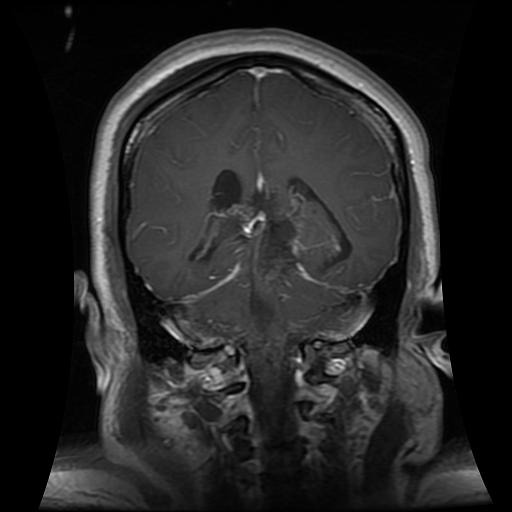

In [8]:
# set seed 
#random.seed(42)

# 1. Get all the images paths 
image_path_list = list(dataset1.glob('*/*/*.jpg'))

# 2. pick a ranom image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of teh directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. print metadata
print(f'Random image path is : {random_image_path}')
print(f'Image class : {image_class}')
print(f'Image height : {img.height}')
print(f'Image width : {img.width}')
img

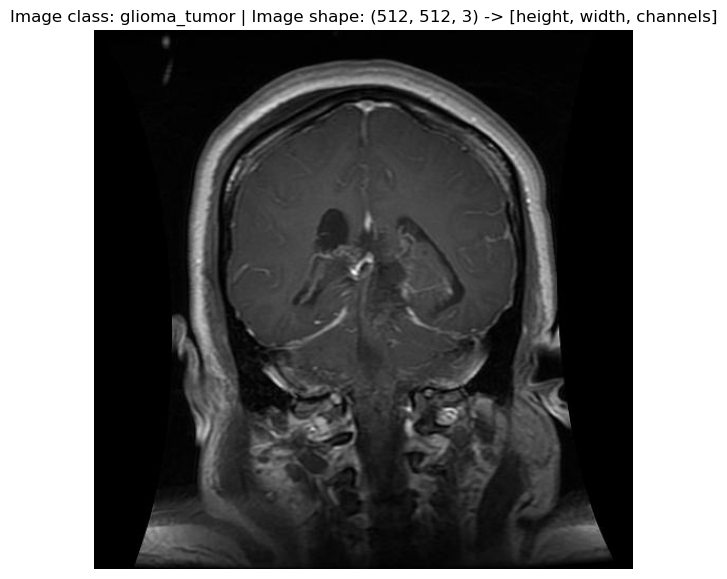

In [9]:
# display an image with plt

# 1. Turn the image into an array 
img_as_array = np.asarray(img)

# 2. plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, channels]')
plt.axis(False)
plt.show()

## 2.0 Visulaise 9 images of each 3 from different category 

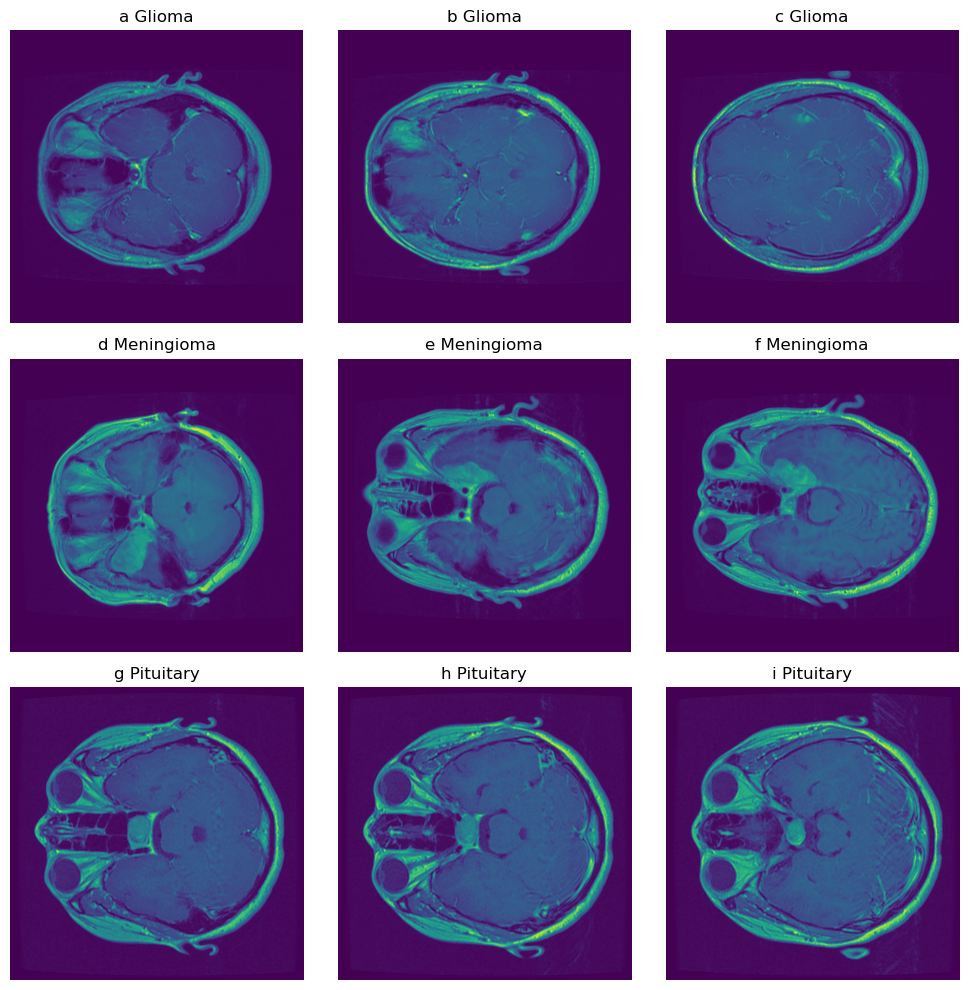

In [9]:
glioma_dir = r'C:\Users\ROG\Desktop\deep-learning\brain_tumor\data\2nd_dataset\Training\glioma'  
meningioma_dir = r'C:\Users\ROG\Desktop\deep-learning\brain_tumor\data\2nd_dataset\Training\meningioma'  
pituitary_dir = r'C:\Users\ROG\Desktop\deep-learning\brain_tumor\data\2nd_dataset\Training\pituitary_tumor'  


glioma_images = [Image.open(os.path.join(glioma_dir, img_file)) for img_file in os.listdir(glioma_dir)[:3]]
meningioma_images = [Image.open(os.path.join(meningioma_dir, img_file)) for img_file in os.listdir(meningioma_dir)[:3]]
pituitary_images = [Image.open(os.path.join(pituitary_dir, img_file)) for img_file in os.listdir(pituitary_dir)[:3]]

# Combine all images and labels
all_images = glioma_images + meningioma_images + pituitary_images
labels = ['Glioma', 'Meningioma', 'Pituitary']  # Tumor type labels
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']  # Letter labels for the images

# Create a figure and plot images 3 per row
plt.figure(figsize=(10, 10))

for i, img in enumerate(all_images):
    plt.subplot(3, 3, i+1)  # 3 rows, 3 columns
    plt.imshow(img)
    
    # Add title as letter ('a', 'b', etc.) and the tumor type on the left
    plt.title(f"{letters[i]} {labels[i // 3]}" , loc='center', fontsize=12)
    plt.ylabel(f"{labels[i // 3]}", fontsize=12)  # Add tumor type label on the left
    
    plt.axis('off')  # Remove axis labels

plt.tight_layout()
plt.show()


## 2.1 Preprocess the data (remove unwanted noise)

Let's write some code to : 
1. Change the image to gray scale
2. Add gaussianblur filter to the images
3. Apply threshold and series of erosions and dilations to remove small regions of noise
4. Find the contours in the thresholded images
5. Draw the contoures on a copy of the original image
7. Find the extreme points
8. Crop the image

In [11]:
def crop_brain_contour(image: np.array, plot=False, save=False):
    """ this image will take the original image and remove noise, find biggest counter, find extreme points, and finally crop the image """
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, and apply a series of erosions & dilations to remove any small regions of noise 
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Create a copy of the image to draw contours on
    image_contour = image.copy()
    cv2.drawContours(image_contour, [c], -1, (0, 255, 0), 2)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Draw the extreme points on the image
    image_extreme_points = image_contour.copy()
    cv2.circle(image_extreme_points, extLeft, 8, (0, 0, 255), -1)
    cv2.circle(image_extreme_points, extRight, 8, (0, 255, 0), -1)
    cv2.circle(image_extreme_points, extTop, 8, (255, 0, 0), -1)
    cv2.circle(image_extreme_points, extBot, 8, (255, 255, 0), -1)

    # Crop the new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    # Save the images
    
    if save:
        save_dir = r'C:\Users\ROG\Desktop\deep-learning\brain_tumor'
        cv2.imwrite(os.path.join(save_dir, 'original_image.jpg'), image)
        cv2.imwrite(os.path.join(save_dir, 'image_contour.jpg'), image_contour)
        cv2.imwrite(os.path.join(save_dir, 'image_extreme_points.jpg'), image_extreme_points)
        cv2.imwrite(os.path.join(save_dir, 'cropped_image.jpg'), new_image)

    if plot:
        plt.figure(figsize=(10, 8))

        plt.subplot(1, 4, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(cv2.cvtColor(image_contour, cv2.COLOR_BGR2RGB))
        plt.title('Biggest Contour')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(cv2.cvtColor(image_extreme_points, cv2.COLOR_BGR2RGB))
        plt.title('Extreme Points')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
        plt.title('Cropped Image')
        plt.axis('off')

        plt.show()

    return new_image


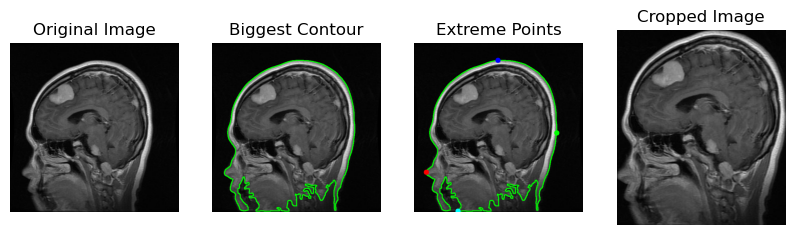

The shape of the cropped image is now : (457, 395, 3) -> [height, width, channels]


In [12]:
new_image = crop_brain_contour(img_as_array, plot=True, save=False)
print(f'The shape of the cropped image is now : {new_image.shape} -> [height, width, channels]')

## 2.2 Crop all images using `crop_brain_contour` function

In [12]:
def process_images_in_directory(input_dir, output_dir, plot=False):
    # make output dir if not exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # loop through all files in the input dir
    for filename in os.listdir(input_dir):
        file_path = os.path.join(input_dir, filename)
        
    
        # check if the file is an image 
        if filename.lower().endswith(('.jpg', '.png')):
            
            image = cv2.imread(file_path)
            
            cropped_image = crop_brain_contour(image, plot=plot)

            output_file_path = os.path.join(output_dir, filename)
    
            cv2.imwrite(output_file_path, cropped_image)
    
            print(f'processed and saved: {filename}')
    

In [79]:
# crop all training images 
glioma_tumor = r'data/2st_data/Training/glioma_tumor'
glioma_tumor_out = r'data/cropped_images/2st_data/Training/glioma_tumor'

meningioma_tumor = r'data/2st_data/Training/meningioma_tumor'
meningioma_tumor_out = r'data/cropped_images/2st_data/Training/meningioma_tumor'

no_tumor = r'data/2st_data/Training/no_tumor'
no_tumor_out = r'data/cropped_images/2st_data/Training/no_tumor'

pituitary_tumor = r'data/2st_data/Training/pituitary_tumor'
pituitary_tumor_out = r'data/cropped_images/2st_data/Training/pituitary_tumor'

process_images_in_directory(pituitary_tumor, pituitary_tumor_out)

processed and saved: p (1).jpg
processed and saved: p (10).jpg
processed and saved: p (100).jpg
processed and saved: p (101).jpg
processed and saved: p (102).jpg
processed and saved: p (103).jpg
processed and saved: p (104).jpg
processed and saved: p (105).jpg
processed and saved: p (106).jpg
processed and saved: p (107).jpg
processed and saved: p (108).jpg
processed and saved: p (109).jpg
processed and saved: p (11).jpg
processed and saved: p (110).jpg
processed and saved: p (111).jpg
processed and saved: p (112).jpg
processed and saved: p (113).jpg
processed and saved: p (114).jpg
processed and saved: p (115).jpg
processed and saved: p (116).jpg
processed and saved: p (117).jpg
processed and saved: p (118).jpg
processed and saved: p (119).jpg
processed and saved: p (12).jpg
processed and saved: p (120).jpg
processed and saved: p (121).jpg
processed and saved: p (122).jpg
processed and saved: p (123).jpg
processed and saved: p (124).jpg
processed and saved: p (125).jpg
processed and s

In [83]:
# crop all testing images
glioma_tumor = r'data/2st_data/Testing/glioma_tumor'
glioma_tumor_out = r'data/cropped_images/2st_data/Testing/glioma_tumor'

meningioma_tumor = r'data/2st_data/Testing/meningioma_tumor'
meningioma_tumor_out = r'data/cropped_images/2st_data/Testing/meningioma_tumor'

no_tumor = r'data/2st_data/Testing/no_tumor'
no_tumor_out = r'data/cropped_images/2st_data/Testing/no_tumor'

pituitary_tumor = r'data/2st_data/Testing/pituitary_tumor'
pituitary_tumor_out = r'data/cropped_images/2st_data/Testing/pituitary_tumor'

process_images_in_directory(pituitary_tumor, pituitary_tumor_out)

processed and saved: image(1).jpg
processed and saved: image(10).jpg
processed and saved: image(11).jpg
processed and saved: image(13).jpg
processed and saved: image(15).jpg
processed and saved: image(18).jpg
processed and saved: image(19).jpg
processed and saved: image(2).jpg
processed and saved: image(20).jpg
processed and saved: image(21).jpg
processed and saved: image(22).jpg
processed and saved: image(23).jpg
processed and saved: image(27).jpg
processed and saved: image(28).jpg
processed and saved: image(3).jpg
processed and saved: image(30).jpg
processed and saved: image(31).jpg
processed and saved: image(34).jpg
processed and saved: image(35).jpg
processed and saved: image(36).jpg
processed and saved: image(37).jpg
processed and saved: image(38).jpg
processed and saved: image(41).jpg
processed and saved: image(42).jpg
processed and saved: image(43).jpg
processed and saved: image(44).jpg
processed and saved: image(45).jpg
processed and saved: image(46).jpg
processed and saved: im

In [11]:
# Reassign Training and Testing sets for 1st_dataset
data_path = Path('data/')
dataset1_cropped = data_path / 'filtered_images' / '2nd_data'

train_dir = dataset1_cropped / 'Training'
test_dir = dataset1_cropped / 'Testing'

walk_throught_dir(train_dir)

There are 3 directories and 0 images in data\filtered_images\2nd_data\Training.
There are 0 directories and 1127 images in data\filtered_images\2nd_data\Training\glioma.
There are 0 directories and 496 images in data\filtered_images\2nd_data\Training\meningioma.
There are 0 directories and 661 images in data\filtered_images\2nd_data\Training\pituitary_tumor.


# 3. Create a Datasets and DataLoaders

Now we have got the data cropped and ready to be processed into a PyTorch DataLoaders.

To do so, we can : 
1. Manually created transforms - you define what transforms you want your data to go through.
2. Automatically created transforms - the transforms for you data are defined by the model you'd like to use

Important Note: when using pretrained model, it's important that the data (including our custom data) that we pass through it is **transformed** in the same way the data of the model was trained on

**Here we will use the second option (Automatically)**

In [10]:
weights = torchvision.models.ConvNeXt_Base_Weights.DEFAULT
auto_transforms_base = weights.transforms()
auto_transforms_base

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [11]:
# Reassign Training and Testing sets for 1st_dataset
data_path = Path('data/')
dataset1_cropped = data_path / 'filtered_images' / '2nd_data'

train_dir = dataset1_cropped / 'Training'
test_dir = dataset1_cropped / 'Testing'

walk_throught_dir(train_dir)

There are 3 directories and 0 images in data\filtered_images\2nd_data\Training.
There are 0 directories and 1127 images in data\filtered_images\2nd_data\Training\glioma.
There are 0 directories and 496 images in data\filtered_images\2nd_data\Training\meningioma.
There are 0 directories and 661 images in data\filtered_images\2nd_data\Training\pituitary_tumor.


In [12]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

def create_dataloaders(train_dir:str, test_dir:str, transform:transforms.Compose, batch_size:int, num_workers:int=NUM_WORKERS):
    """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers, 
        pin_memory=True
    )

    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,        
    )

    return train_dataloader, test_dataloader, class_names

In [13]:
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir, test_dir, auto_transforms_base, BATCH_SIZE)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x202d788a110>,
 ['glioma', 'meningioma', 'pituitary_tumor'])

# 4. Getting a pretrained model 
There are various places to get pretrained model but we will use PyTorch domain libraries

we will get ConvNext

In [28]:
weights = torchvision.models.ConvNeXt_Base_Weights.DEFAULT # DEFAULT = best availabel model to use 
model = torchvision.models.convnext_base(weights=weights).to(device)
model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

### 4.1 Getting a summary of our model with torchinfo.summary()

In [29]:
summary(model=model,
       input_size=(1, 3, 224, 224), #example of [batch_size, color_channels, height, width]
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names'])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                 [1, 3, 224, 224]     [1, 1024, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                         [1, 3, 224, 224]     [1, 128, 56, 56]     --                   True
│    │    └─Conv2d (0)                                  [1, 3, 224, 224]     [1, 128, 56, 56]     6,272                True
│    │    └─LayerNorm2d (1)                             [1, 128, 56, 56]     [1, 128, 56, 56]     256                  True
│    └─Sequential (1)                                   [1, 128, 56, 56]     [1, 128, 56, 56]     --                   True
│    │    └─CNBlock (0)                                 [1, 128, 56, 56]     [1, 128, 56, 56]     138,496              True
│  

### 4.2 Freezing the base model and changin the output layer to suit our needs (Fine-tunning)
### Adding Black Cell Block
With a feature extractor model, typically we will 'freeze' the base layers of a pretrained/foundation model and update the output layers to suit our problem

In [30]:
# Freezer all of the base layers in EffNetB0
for param in model.features.parameters():
    param.requires_grad = False

In [32]:
# Update the classifier head of our model to suit our problem 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    # nn.LayerNorm([BATCH_SIZE, 1024, 1 ,1]),
    nn.Flatten(),
    nn.BatchNorm1d(num_features=1024),  # Batch Norm after Global Average Pooling   
    nn.Linear(in_features=1024, out_features=512, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=512),   # Batch Norm after first Linear layer
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=512, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256),   # Batch Norm after second Linear layer
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=256, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256), 
    nn.Linear(in_features=256, out_features=len(class_names), bias=True)
)
model.classifier

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): SiLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Dropout(p=0.5, inplace=True)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): SiLU()
  (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Dropout(p=0.5, inplace=True)
  (10): Linear(in_features=256, out_features=256, bias=True)
  (11): SiLU()
  (12): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Linear(in_features=256, out_features=3, bias=True)
)

In [33]:
summary(model=model,
       input_size=(1, 3, 224, 224), #example of [batch_size, color_channels, height, width]
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names']) 

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                 [1, 3, 224, 224]     [1, 1024, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                         [1, 3, 224, 224]     [1, 128, 56, 56]     --                   False
│    │    └─Conv2d (0)                                  [1, 3, 224, 224]     [1, 128, 56, 56]     (6,272)              False
│    │    └─LayerNorm2d (1)                             [1, 128, 56, 56]     [1, 128, 56, 56]     (256)                False
│    └─Sequential (1)                                   [1, 128, 56, 56]     [1, 128, 56, 56]     --                   False
│    │    └─CNBlock (0)                                 [1, 128, 56, 56]     [1, 128, 56, 56]     (138,496)            

In [20]:
# setting loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 5. Evaluation and Testing Functions 
The *evaluate_model()* function is designed to assess the performance of a trained deep learning model on a test dataset. It provides key evaluation metrics, including overall accuracy, classification report (precision, recall, F1-score for each class), specificity for each class, and a confusion matrix to visualize the model's predictions.

The function operates by passing test images through the model, comparing predictions to the true labels, and calculating metrics to quantify performance. This ensures a comprehensive evaluation, helping to identify strengths and weaknesses in class-specific performance. Additionally, the function allows visualization of the confusion matrix, making it easy to spot misclassifications.

The *evaluate_training_testing_model* is used to get overall accuracy, precision, recall, F1-score, and specificity.

In [14]:
# Function to calculate specificity
def calculate_specificity(conf_matrix):
    specificity = []
    for i in range(len(conf_matrix)):
        true_negatives = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
        false_positives = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
        specificity_value = true_negatives / (true_negatives + false_positives)
        specificity.append(specificity_value)
    return specificity

# Function to calculate accuracy for each class
def calculate_class_accuracy(conf_matrix):
    accuracy = []
    for i in range(len(conf_matrix)):
        true_positives = conf_matrix[i, i]
        total_samples = np.sum(conf_matrix[i])
        accuracy_value = true_positives / total_samples
        accuracy.append(accuracy_value)
    return accuracy

# Function to evaluate the model on the test set
def evaluate_model(model, test_dataloader, class_names, device):
    model.eval()  # Set model to evaluation mode
    y_pred = []
    y_true = []
    
    with torch.no_grad():  # Disable gradient calculations
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Store predictions and true labels
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Calculate and print overall accuracy
    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    # Calculate and print accuracy for each class
    class_accuracies = calculate_class_accuracy(conf_matrix)
    for i, accuracy in enumerate(class_accuracies):
        print(f"Accuracy for {class_names[i]}: {accuracy:.4f}")
    
    # Calculate and print specificity for each class
    specificity_values = calculate_specificity(conf_matrix)
    for i, specificity in enumerate(specificity_values):
        print(f"Specificity for {class_names[i]}: {specificity:.4f}")
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_training_testing_model(model, train_dataloader, test_dataloader, class_names, device):
    def get_predictions_labels(dataloader):
        model.eval()  # Set model to evaluation mode
        y_pred = []
        y_true = []

        with torch.no_grad():  # Disable gradient calculations
            for images, labels in tqdm(dataloader):
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                _, preds = torch.max(outputs, 1)

                # Store predictions and true labels
                y_pred.extend(preds.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

        return y_true, y_pred

    def calculate_overall_specificity(conf_matrix):
        # Specificity: (True Negatives) / (True Negatives + False Positives)
        total_specificity = 0
        num_classes = len(conf_matrix)
        
        for i in range(num_classes):
            true_negatives = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
            false_positives = np.sum(np.delete(conf_matrix[i], i))
            class_specificity = true_negatives / (true_negatives + false_positives)
            total_specificity += class_specificity
        
        overall_specificity = total_specificity / num_classes
        return overall_specificity

    # Get training and testing predictions and labels
    y_train_true, y_train_pred = get_predictions_labels(train_dataloader)
    y_test_true, y_test_pred = get_predictions_labels(test_dataloader)

    # Calculate confusion matrices
    conf_matrix_train = confusion_matrix(y_train_true, y_train_pred)
    conf_matrix_test = confusion_matrix(y_test_true, y_test_pred)

    # Training Metrics
    print("\n=== Training Metrics ===")
    train_accuracy = accuracy_score(y_train_true, y_train_pred)
    train_precision = precision_score(y_train_true, y_train_pred, average='weighted')
    train_recall = recall_score(y_train_true, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train_true, y_train_pred, average='weighted')
    train_specificity = calculate_overall_specificity(conf_matrix_train)

    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Training Precision: {train_precision:.4f}")
    print(f"Training Recall: {train_recall:.4f}")
    print(f"Training F1-Score: {train_f1:.4f}")
    print(f"Overall Training Specificity: {train_specificity:.4f}")

    # Testing Metrics
    print("\n=== Testing Metrics ===")
    test_accuracy = accuracy_score(y_test_true, y_test_pred)
    test_precision = precision_score(y_test_true, y_test_pred, average='weighted')
    test_recall = recall_score(y_test_true, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test_true, y_test_pred, average='weighted')
    test_specificity = calculate_overall_specificity(conf_matrix_test)

    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Testing Precision: {test_precision:.4f}")
    print(f"Testing Recall: {test_recall:.4f}")
    print(f"Testing F1-Score: {test_f1:.4f}")
    print(f"Overall Testing Specificity: {test_specificity:.4f}")

    # Confusion Matrix for Testing
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (Testing)")
    plt.show()


# Convnext_base

In [27]:
# Load ConvexNet_base
weights = torchvision.models.ConvNeXt_Base_Weights.DEFAULT
model = torchvision.models.convnext_base(weights=weights).to(device)

# Update the classifier head of our model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for param in model.features.parameters():
    param.requires_grad = False

# Define the new classifier head 
model.classifier = nn.Sequential(
    # nn.LayerNorm([BATCH_SIZE, 1024, 1 ,1]),
    nn.Flatten(),
    nn.BatchNorm1d(num_features=1024),  # Batch Norm after Global Average Pooling   
    nn.Linear(in_features=1024, out_features=512, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=512),   # Batch Norm after first Linear layer
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=512, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256),   # Batch Norm after second Linear layer
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=256, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256), 
    nn.Linear(in_features=256, out_features=len(class_names), bias=True)
)


# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move model to the appropriate device
model = model.to(device)

summary(model=model,
       input_size=(32, 3, 224, 224), #example of [batch_size, color_channels, height, width]
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names'])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 1024, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 128, 56, 56]    --                   False
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 128, 56, 56]    (6,272)              False
│    │    └─LayerNorm2d (1)                             [32, 128, 56, 56]    [32, 128, 56, 56]    (256)                False
│    └─Sequential (1)                                   [32, 128, 56, 56]    [32, 128, 56, 56]    --                   False
│    │    └─CNBlock (0)                                 [32, 128, 56, 56]    [32, 128, 56, 56]    (138,496)            

In [22]:
# Reassign Training and Testing sets for 1st_dataset
data_path = Path('data/')
dataset1_cropped = data_path / 'filtered_images' / '2nd_data' 

train_dir = dataset1_cropped / 'Training'
test_dir = dataset1_cropped / 'Testing'

walk_throught_dir(test_dir)

There are 3 directories and 0 images in data\filtered_images\2nd_data\Testing.
There are 0 directories and 275 images in data\filtered_images\2nd_data\Testing\glioma.
There are 0 directories and 128 images in data\filtered_images\2nd_data\Testing\meningioma.
There are 0 directories and 179 images in data\filtered_images\2nd_data\Testing\pituitary_tumor.


### Train With AUG

In [19]:
# we need to run this before running the evaluation code and choose the model that we want to evaluate

weights_base = torchvision.models.ConvNeXt_Base_Weights.DEFAULT

weights_small = torchvision.models.ConvNeXt_Small_Weights.DEFAULT

weights_large = torchvision.models.ConvNeXt_Large_Weights.DEFAULT

weights_tiny = torchvision.models.ConvNeXt_Tiny_Weights.DEFAULT

auto_transforms_convnext = weights_base.transforms()

# add data augmentation

data_augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),         
    transforms.RandomVerticalFlip(p=0.2),           
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    auto_transforms_convnext
])

train_dataloader, test_dataloader, class_names=create_dataloaders(train_dir, test_dir,transform=data_augmentation_transforms, batch_size=BATCH_SIZE)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x202d74af910>,
 ['glioma', 'meningioma', 'pituitary_tumor'])

### Train Without AUG

In [26]:
weights = torchvision.models.ConvNeXt_Base_Weights.DEFAULT
auto_transforms_convnext = weights.transforms()

# data augmentation applied on dataset

data_transforms = transforms.Compose([
    auto_transforms_convnext    
])

train_dataloader, test_dataloader, class_names=create_dataloaders(train_dir, test_dir,transform=data_transforms, batch_size=BATCH_SIZE)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1bc499c7490>,
 ['glioma', 'meningioma', 'pituitary_tumor'])

In [28]:
# Set the manual seeds 

# without AUG
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
start_time = timer()

# setup training and save the result
results = engine.train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader= test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=100,
                      device=device)

# End the timer 
end_time = timer()

print(f'[INGO] Total training time: {end_time - start_time:.3f} seconds')

# we got 98.85

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3481 | train_acc: 0.8611 | test_loss: 0.1462 | test_acc: 0.9539
Epoch: 2 | train_loss: 0.2213 | train_acc: 0.9242 | test_loss: 0.1399 | test_acc: 0.9572
Epoch: 3 | train_loss: 0.2190 | train_acc: 0.9217 | test_loss: 0.1044 | test_acc: 0.9720
Epoch: 4 | train_loss: 0.1917 | train_acc: 0.9284 | test_loss: 0.1116 | test_acc: 0.9622
Epoch: 5 | train_loss: 0.1656 | train_acc: 0.9395 | test_loss: 0.1032 | test_acc: 0.9633
Epoch: 6 | train_loss: 0.1514 | train_acc: 0.9439 | test_loss: 0.1046 | test_acc: 0.9671
Epoch: 7 | train_loss: 0.1238 | train_acc: 0.9553 | test_loss: 0.0812 | test_acc: 0.9720
Epoch: 8 | train_loss: 0.1332 | train_acc: 0.9476 | test_loss: 0.1129 | test_acc: 0.9633
Epoch: 9 | train_loss: 0.1508 | train_acc: 0.9463 | test_loss: 0.0705 | test_acc: 0.9803
Epoch: 10 | train_loss: 0.1171 | train_acc: 0.9585 | test_loss: 0.0704 | test_acc: 0.9819
Epoch: 11 | train_loss: 0.1163 | train_acc: 0.9596 | test_loss: 0.0722 | test_acc: 0.9737
Epoch: 12 | train_l

In [ ]:
# save the model 
torch.save(model.state_dict(), 'ConvNextBaseNoAug.pth')

In [29]:
# train with data aug 
# Start the timer
start_time = timer()

# setup training and save the result
results = engine.train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader= test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=100,
                      device=device)

# End the timer 
end_time = timer()

print(f'[INGO] Total training time: {end_time - start_time:.3f} seconds')
#best with aug is 9918

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3337 | train_acc: 0.8681 | test_loss: 0.1434 | test_acc: 0.9424
Epoch: 2 | train_loss: 0.2215 | train_acc: 0.9207 | test_loss: 0.1777 | test_acc: 0.9265
Epoch: 3 | train_loss: 0.2015 | train_acc: 0.9225 | test_loss: 0.1066 | test_acc: 0.9622
Epoch: 4 | train_loss: 0.2092 | train_acc: 0.9240 | test_loss: 0.1172 | test_acc: 0.9572
Epoch: 5 | train_loss: 0.1897 | train_acc: 0.9313 | test_loss: 0.0840 | test_acc: 0.9770
Epoch: 6 | train_loss: 0.1477 | train_acc: 0.9465 | test_loss: 0.1062 | test_acc: 0.9589
Epoch: 7 | train_loss: 0.1530 | train_acc: 0.9455 | test_loss: 0.1135 | test_acc: 0.9616
Epoch: 8 | train_loss: 0.1350 | train_acc: 0.9501 | test_loss: 0.1009 | test_acc: 0.9671
Epoch: 9 | train_loss: 0.1603 | train_acc: 0.9436 | test_loss: 0.0986 | test_acc: 0.9589
Epoch: 10 | train_loss: 0.1181 | train_acc: 0.9618 | test_loss: 0.0973 | test_acc: 0.9649
Epoch: 11 | train_loss: 0.1444 | train_acc: 0.9462 | test_loss: 0.0828 | test_acc: 0.9638
Epoch: 12 | train_l

In [29]:
# save the model 
torch.save(model.state_dict(), 'ConvNextBaseNoAug.pth')

### Evaluate the Model

#### class-wise evaluation

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:09<00:00,  1.90it/s]

Overall Accuracy: 0.9914

Classification Report:
                 precision    recall  f1-score   support

         glioma     1.0000    0.9927    0.9964       275
     meningioma     0.9697    1.0000    0.9846       128
pituitary_tumor     0.9944    0.9832    0.9888       179

       accuracy                         0.9914       582
      macro avg     0.9880    0.9920    0.9899       582
   weighted avg     0.9916    0.9914    0.9914       582

Accuracy for glioma: 0.9927
Accuracy for meningioma: 1.0000
Accuracy for pituitary_tumor: 0.9832
Specificity for glioma: 1.0000
Specificity for meningioma: 0.9912
Specificity for pituitary_tumor: 0.9975


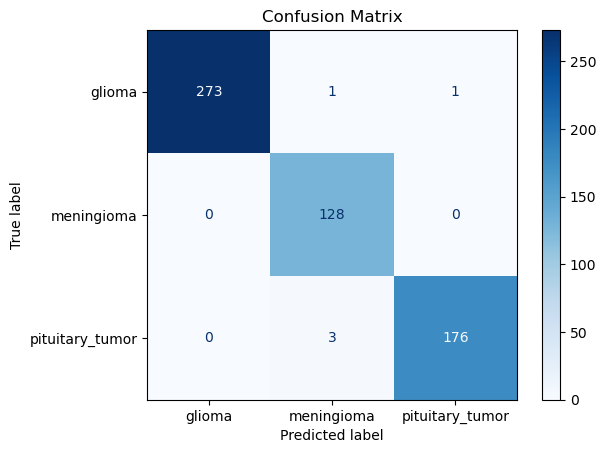

In [68]:
# Add seeding 
SEED = 42 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Step 1: Load the Saved Model
model = torchvision.models.convnext_base(weights=None).to(device)  # Use the same model architecture
# Step 2: make sure all the hyperparameters are the same  ( you have to change the code below depending on the model you add)
model.classifier = nn.Sequential(
    # nn.LayerNorm([BATCH_SIZE, 1024, 1 ,1]),
    nn.Flatten(),
    nn.BatchNorm1d(num_features=1024),  # Batch Norm after Global Average Pooling   
    nn.Linear(in_features=1024, out_features=512, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=512),   # Batch Norm after first Linear layer
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=512, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256),   # Batch Norm after second Linear layer
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=256, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256), 
    nn.Linear(in_features=256, out_features=len(class_names), bias=True)
)

model.load_state_dict(torch.load("CNBAug_state_dict.pth"))  # Load the model weights
model.to(device)


evaluate_model(model=model, test_dataloader=test_dataloader, class_names=class_names, device=device)


#### Over-all evaluation with AUG

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.86it/s]


=== Training Metrics ===
Training Accuracy: 0.9991
Training Precision: 0.9991
Training Recall: 0.9991
Training F1-Score: 0.9991
Overall Training Specificity: 0.9996

=== Testing Metrics ===
Testing Accuracy: 0.9931
Testing Precision: 0.9933
Testing Recall: 0.9931
Testing F1-Score: 0.9932
Overall Testing Specificity: 0.9962


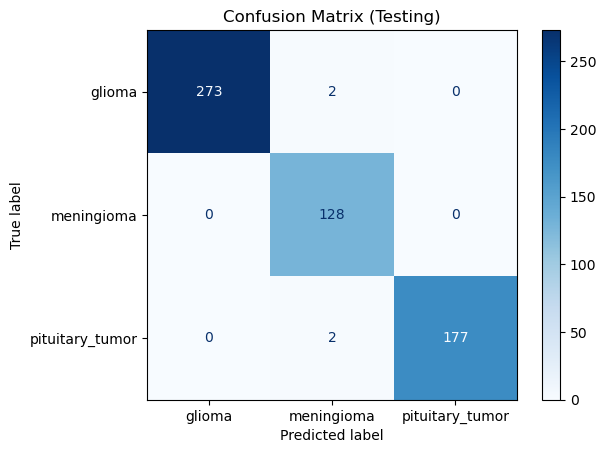

In [55]:
SEED = 42
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

evaluate_training_testing_model(model=model, 
                                train_dataloader=train_dataloader, 
                                test_dataloader=test_dataloader, 
                                class_names=class_names, 
                                device=device)


#### Over-all evaluation without AUG

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:09<00:00,  1.94it/s]


=== Training Metrics ===
Training Accuracy: 1.0000
Training Precision: 1.0000
Training Recall: 1.0000
Training F1-Score: 1.0000
Overall Training Specificity: 1.0000

=== Testing Metrics ===
Testing Accuracy: 0.9777
Testing Precision: 0.9776
Testing Recall: 0.9777
Testing F1-Score: 0.9776
Overall Testing Specificity: 0.9892


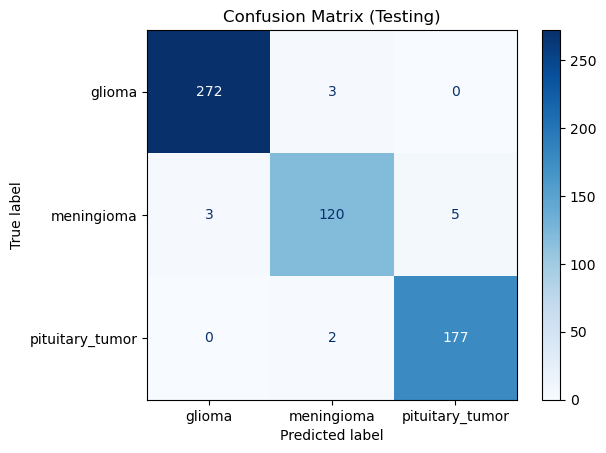

In [34]:
# SEED = 42
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

evaluate_training_testing_model(model=model, 
                                train_dataloader=train_dataloader, 
                                test_dataloader=test_dataloader, 
                                class_names=class_names, 
                                device=device)


# ConvNext large

In [21]:
#weights = torchvision.models.ConvNeXt_Large_Weights.DEFAULT
model = torchvision.models.convnext_large(weights=weights_large).to(device)

# Update the classifier head of our model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for param in model.features.parameters():
    param.requires_grad = False

# Define the new classifier head

model.classifier = nn.Sequential(
    # nn.LayerNorm([BATCH_SIZE, 1024, 1 ,1]),
    nn.Flatten(),
    nn.BatchNorm1d(num_features=1536),  # Batch Norm after Global Average Pooling   
    nn.Linear(in_features=1536, out_features=512, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=512),   # Batch Norm after first Linear layer
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=512, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256),   # Batch Norm after second Linear layer
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=256, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256),
    nn.Linear(in_features=256, out_features=len(class_names), bias=True)
)


# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move model to the appropriate device
model = model.to(device)

summary(model=model,
       input_size=(32, 3, 224, 224), #example of [batch_size, color_channels, height, width]
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names']) 

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 1536, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 192, 56, 56]    --                   False
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 192, 56, 56]    (9,408)              False
│    │    └─LayerNorm2d (1)                             [32, 192, 56, 56]    [32, 192, 56, 56]    (384)                False
│    └─Sequential (1)                                   [32, 192, 56, 56]    [32, 192, 56, 56]    --                   False
│    │    └─CNBlock (0)                                 [32, 192, 56, 56]    [32, 192, 56, 56]    (306,048)            

In [15]:
weights = torchvision.models.ConvNeXt_Large_Weights.DEFAULT
auto_transforms_convnext_large = weights.transforms()

train_dataloader, test_dataloader, class_names=create_dataloaders(train_dir, test_dir, transform=auto_transforms_convnext_large, batch_size=BATCH_SIZE)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x273619d6510>,
 ['glioma', 'meningioma', 'pituitary_tumor'])

In [18]:
# Set the manual seeds 

# Train with AUG

# Start the timer
start_time = timer()

# setup training and save the result
results = engine.train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader= test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=100,
                      device=device)

# End the timer 
end_time = timer()

print(f'[INGO] Total training time: {end_time - start_time:.3f} seconds')

# we got 98.68

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3555 | train_acc: 0.8594 | test_loss: 0.1688 | test_acc: 0.9216
Epoch: 2 | train_loss: 0.2560 | train_acc: 0.9103 | test_loss: 0.1607 | test_acc: 0.9435
Epoch: 3 | train_loss: 0.2257 | train_acc: 0.9212 | test_loss: 0.1410 | test_acc: 0.9435
Epoch: 4 | train_loss: 0.2040 | train_acc: 0.9236 | test_loss: 0.1344 | test_acc: 0.9474
Epoch: 5 | train_loss: 0.1826 | train_acc: 0.9327 | test_loss: 0.1389 | test_acc: 0.9380
Epoch: 6 | train_loss: 0.1625 | train_acc: 0.9359 | test_loss: 0.1191 | test_acc: 0.9550
Epoch: 7 | train_loss: 0.1705 | train_acc: 0.9417 | test_loss: 0.1070 | test_acc: 0.9567
Epoch: 8 | train_loss: 0.1734 | train_acc: 0.9336 | test_loss: 0.0893 | test_acc: 0.9600
Epoch: 9 | train_loss: 0.1670 | train_acc: 0.9397 | test_loss: 0.1176 | test_acc: 0.9430
Epoch: 10 | train_loss: 0.1700 | train_acc: 0.9361 | test_loss: 0.0827 | test_acc: 0.9737
Epoch: 11 | train_loss: 0.1285 | train_acc: 0.9562 | test_loss: 0.0775 | test_acc: 0.9605
Epoch: 12 | train_l

In [ ]:
# save the model 
torch.save(model.state_dict(), 'ConvNextLargeAug.pth')

In [22]:
# Set the manual seeds 

# Train with no AUG

# Start the timer
start_time = timer()

# setup training and save the result
results = engine.train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader= test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=100,
                      device=device)

# End the timer 
end_time = timer()

print(f'[INGO] Total training time: {end_time - start_time:.3f} seconds')

# we got 98.68

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3650 | train_acc: 0.8547 | test_loss: 0.1443 | test_acc: 0.9402
Epoch: 2 | train_loss: 0.2395 | train_acc: 0.9117 | test_loss: 0.1317 | test_acc: 0.9501
Epoch: 3 | train_loss: 0.2127 | train_acc: 0.9164 | test_loss: 0.1287 | test_acc: 0.9490
Epoch: 4 | train_loss: 0.1992 | train_acc: 0.9238 | test_loss: 0.1232 | test_acc: 0.9539
Epoch: 5 | train_loss: 0.1652 | train_acc: 0.9410 | test_loss: 0.1339 | test_acc: 0.9550
Epoch: 6 | train_loss: 0.1363 | train_acc: 0.9514 | test_loss: 0.0953 | test_acc: 0.9720
Epoch: 7 | train_loss: 0.1496 | train_acc: 0.9481 | test_loss: 0.0843 | test_acc: 0.9622
Epoch: 8 | train_loss: 0.1453 | train_acc: 0.9520 | test_loss: 0.1058 | test_acc: 0.9671
Epoch: 9 | train_loss: 0.1452 | train_acc: 0.9488 | test_loss: 0.0907 | test_acc: 0.9671
Epoch: 10 | train_loss: 0.1403 | train_acc: 0.9486 | test_loss: 0.0670 | test_acc: 0.9803
Epoch: 11 | train_loss: 0.1212 | train_acc: 0.9612 | test_loss: 0.0925 | test_acc: 0.9671
Epoch: 12 | train_l

In [23]:
# save the model 
torch.save(model.state_dict(), 'ConvNextLargeNoAug.pth')

### Evaluate the model

#### class-wise evaluation

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:12<00:00,  1.47it/s]

Overall Accuracy: 0.9794

Classification Report:
                 precision    recall  f1-score   support

         glioma     0.9855    0.9855    0.9855       275
     meningioma     0.9470    0.9766    0.9615       128
pituitary_tumor     0.9943    0.9721    0.9831       179

       accuracy                         0.9794       582
      macro avg     0.9756    0.9780    0.9767       582
   weighted avg     0.9797    0.9794    0.9795       582

Accuracy for glioma: 0.9855
Accuracy for meningioma: 0.9766
Accuracy for pituitary_tumor: 0.9721
Specificity for glioma: 0.9870
Specificity for meningioma: 0.9846
Specificity for pituitary_tumor: 0.9975


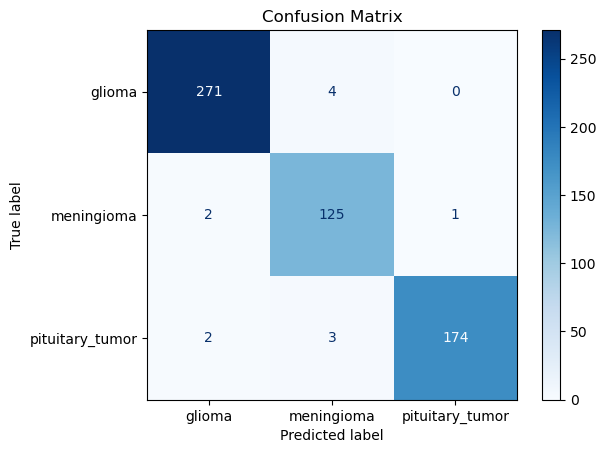

In [75]:
# Add seeding # paper this one 
SEED = 42 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Step 1: Load the Saved Model
model = torchvision.models.convnext_large(weights=None).to(device)  # Use the same model architecture
# Step 2: make sure all the hyperparameters are the same  ( you have to change the code below depending on the model you add)
model.classifier = nn.Sequential(
    # nn.LayerNorm([BATCH_SIZE, 1024, 1 ,1]),
    nn.Flatten(),
    nn.BatchNorm1d(num_features=1536),  # Batch Norm after Global Average Pooling   
    nn.Linear(in_features=1536, out_features=512, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=512),   # Batch Norm after first Linear layer
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=512, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256),   # Batch Norm after second Linear layer
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=256, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256),
    nn.Linear(in_features=256, out_features=len(class_names), bias=True)
)

model.load_state_dict(torch.load("ConvNextLargeAug.pth"))  # Load the model weights
model.to(device)


evaluate_model(model=model, test_dataloader=test_dataloader, class_names=class_names, device=device)


#### over-all evaluation with AUG

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.46it/s]


=== Training Metrics ===
Training Accuracy: 0.9982
Training Precision: 0.9983
Training Recall: 0.9982
Training F1-Score: 0.9982
Overall Training Specificity: 0.9990

=== Testing Metrics ===
Testing Accuracy: 0.9725
Testing Precision: 0.9724
Testing Recall: 0.9725
Testing F1-Score: 0.9725
Overall Testing Specificity: 0.9867


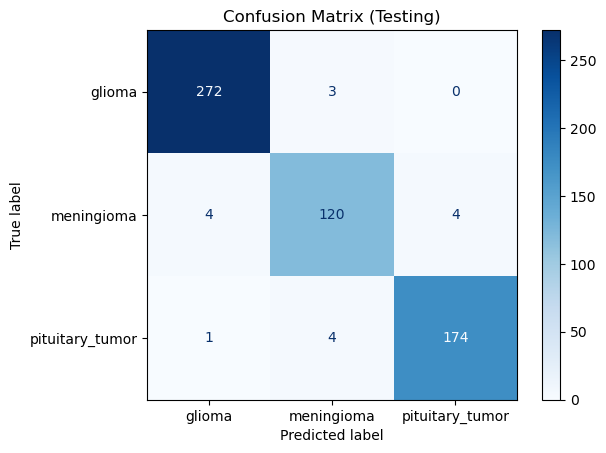

In [74]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

evaluate_training_testing_model(model=model, 
                                train_dataloader=train_dataloader, 
                                test_dataloader=test_dataloader, 
                                class_names=class_names, 
                                device=device)


#### over-all evaluation without AUG

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.44it/s]


=== Training Metrics ===
Training Accuracy: 0.9926
Training Precision: 0.9926
Training Recall: 0.9926
Training F1-Score: 0.9926
Overall Training Specificity: 0.9961

=== Testing Metrics ===
Testing Accuracy: 0.9674
Testing Precision: 0.9679
Testing Recall: 0.9674
Testing F1-Score: 0.9675
Overall Testing Specificity: 0.9832


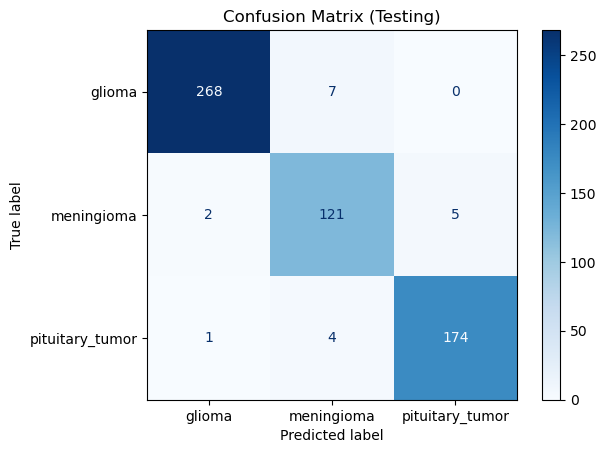

In [95]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

evaluate_training_testing_model(model=model, 
                                train_dataloader=train_dataloader, 
                                test_dataloader=test_dataloader, 
                                class_names=class_names, 
                                device=device)


# ConvNext tiny

In [24]:
weights = torchvision.models.ConvNeXt_Tiny_Weights.DEFAULT
auto_transforms_convnext_tiny = weights.transforms()

train_dataloader, test_dataloader, class_names=create_dataloaders(train_dir, test_dir, transform=auto_transforms_convnext_tiny, batch_size=BATCH_SIZE)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x273ebe7af90>,
 ['glioma', 'meningioma', 'pituitary_tumor'])

In [22]:
model = torchvision.models.convnext_tiny(weights=weights).to(device)

# Update the classifier head of our model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for param in model.features.parameters():
    param.requires_grad = False

# Define the new classifier head

model.classifier = nn.Sequential(
    # nn.LayerNorm([BATCH_SIZE, 1024, 1 ,1]),
    nn.Flatten(),
    nn.BatchNorm1d(num_features=768),  # Batch Norm after Global Average Pooling   
    nn.Linear(in_features=768, out_features=512, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=512),   # Batch Norm after first Linear layer
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=512, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256),   # Batch Norm after second Linear layer
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=256, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256),
    nn.Linear(in_features=256, out_features=len(class_names), bias=True)
)


# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move model to the appropriate device
model = model.to(device)

summary(model=model,
       input_size=(32, 3, 224, 224), #example of [batch_size, color_channels, height, width]
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names']) 

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 768, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 96, 56, 56]     --                   False
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 96, 56, 56]     (4,704)              False
│    │    └─LayerNorm2d (1)                             [32, 96, 56, 56]     [32, 96, 56, 56]     (192)                False
│    └─Sequential (1)                                   [32, 96, 56, 56]     [32, 96, 56, 56]     --                   False
│    │    └─CNBlock (0)                                 [32, 96, 56, 56]     [32, 96, 56, 56]     (79,296)             

In [19]:
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# with AUG

# Start the timer
start_time = timer()

# setup training and save the result
results = engine.train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader= test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=100,
                      device=device)

# End the timer 
end_time = timer()

print(f'[INGO] Total training time: {end_time - start_time:.3f} seconds')

# we got 98.68

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3328 | train_acc: 0.8686 | test_loss: 0.1790 | test_acc: 0.9320
Epoch: 2 | train_loss: 0.2287 | train_acc: 0.9161 | test_loss: 0.1802 | test_acc: 0.9348
Epoch: 3 | train_loss: 0.1971 | train_acc: 0.9313 | test_loss: 0.1130 | test_acc: 0.9589
Epoch: 4 | train_loss: 0.1823 | train_acc: 0.9251 | test_loss: 0.1028 | test_acc: 0.9556
Epoch: 5 | train_loss: 0.1570 | train_acc: 0.9465 | test_loss: 0.1196 | test_acc: 0.9468
Epoch: 6 | train_loss: 0.1506 | train_acc: 0.9423 | test_loss: 0.1166 | test_acc: 0.9485
Epoch: 7 | train_loss: 0.1460 | train_acc: 0.9479 | test_loss: 0.0942 | test_acc: 0.9550
Epoch: 8 | train_loss: 0.1302 | train_acc: 0.9550 | test_loss: 0.1063 | test_acc: 0.9600
Epoch: 9 | train_loss: 0.1202 | train_acc: 0.9544 | test_loss: 0.1037 | test_acc: 0.9655
Epoch: 10 | train_loss: 0.1067 | train_acc: 0.9598 | test_loss: 0.0817 | test_acc: 0.9671
Epoch: 11 | train_loss: 0.1183 | train_acc: 0.9501 | test_loss: 0.0759 | test_acc: 0.9633
Epoch: 12 | train_l

In [23]:
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# with NO AUG

# Start the timer
start_time = timer()

# setup training and save the result
results = engine.train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader= test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=100,
                      device=device)

# End the timer 
end_time = timer()

print(f'[INGO] Total training time: {end_time - start_time:.3f} seconds')

# we got 98.68

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3297 | train_acc: 0.8746 | test_loss: 0.2114 | test_acc: 0.9293
Epoch: 2 | train_loss: 0.2203 | train_acc: 0.9222 | test_loss: 0.1212 | test_acc: 0.9518
Epoch: 3 | train_loss: 0.1612 | train_acc: 0.9401 | test_loss: 0.1442 | test_acc: 0.9556
Epoch: 4 | train_loss: 0.1530 | train_acc: 0.9453 | test_loss: 0.1202 | test_acc: 0.9518
Epoch: 5 | train_loss: 0.1097 | train_acc: 0.9546 | test_loss: 0.0841 | test_acc: 0.9671
Epoch: 6 | train_loss: 0.1037 | train_acc: 0.9657 | test_loss: 0.0939 | test_acc: 0.9720
Epoch: 7 | train_loss: 0.0903 | train_acc: 0.9666 | test_loss: 0.0768 | test_acc: 0.9720
Epoch: 8 | train_loss: 0.1001 | train_acc: 0.9644 | test_loss: 0.0839 | test_acc: 0.9633
Epoch: 9 | train_loss: 0.0775 | train_acc: 0.9744 | test_loss: 0.0883 | test_acc: 0.9737
Epoch: 10 | train_loss: 0.0678 | train_acc: 0.9757 | test_loss: 0.0706 | test_acc: 0.9753
Epoch: 11 | train_loss: 0.0921 | train_acc: 0.9670 | test_loss: 0.0982 | test_acc: 0.9649
Epoch: 12 | train_l

In [24]:
# save the model 
torch.save(model.state_dict(), 'ConvNextTinyNoAug.pth')

### Evaluate the Model

#### Evaluate class-wise

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:07<00:00,  2.40it/s]

Overall Accuracy: 0.9845

Classification Report:
                 precision    recall  f1-score   support

         glioma     0.9927    0.9855    0.9891       275
     meningioma     0.9612    0.9688    0.9650       128
pituitary_tumor     0.9889    0.9944    0.9916       179

       accuracy                         0.9845       582
      macro avg     0.9809    0.9829    0.9819       582
   weighted avg     0.9846    0.9845    0.9846       582

Accuracy for glioma: 0.9855
Accuracy for meningioma: 0.9688
Accuracy for pituitary_tumor: 0.9944
Specificity for glioma: 0.9935
Specificity for meningioma: 0.9890
Specificity for pituitary_tumor: 0.9950


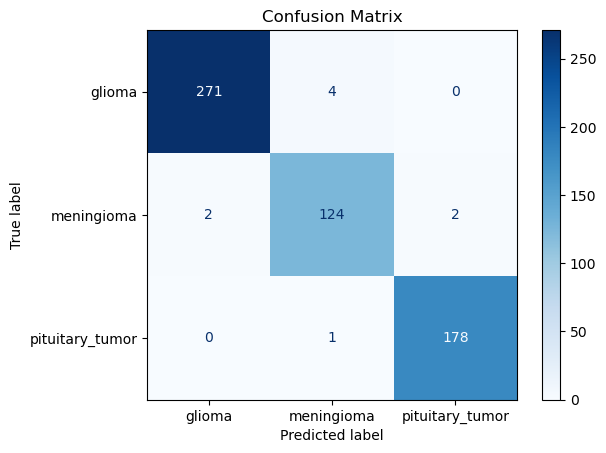

In [82]:
# Add seeding 
SEED = 42 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Step 1: Load the Saved Model
model = torchvision.models.convnext_tiny(weights=None).to(device)  # Use the same model architecture
# Step 2: make sure all the hyperparameters are the same  ( you have to change the code below depending on the model you add)
model.classifier = nn.Sequential(
    # nn.LayerNorm([BATCH_SIZE, 1024, 1 ,1]),
    nn.Flatten(),
    nn.BatchNorm1d(num_features=768),  # Batch Norm after Global Average Pooling   
    nn.Linear(in_features=768, out_features=512, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=512),   # Batch Norm after first Linear layer
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=512, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256),   # Batch Norm after second Linear layer
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=256, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256),
    nn.Linear(in_features=256, out_features=len(class_names), bias=True)
)

model.load_state_dict(torch.load("ConvNextTinyAug.pth"))  # Load the model weights
model.to(device)


evaluate_model(model=model, test_dataloader=test_dataloader, class_names=class_names, device=device)


#### Evaluate over all with AUG

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:08<00:00,  2.35it/s]


=== Training Metrics ===
Training Accuracy: 1.0000
Training Precision: 1.0000
Training Recall: 1.0000
Training F1-Score: 1.0000
Overall Training Specificity: 1.0000

=== Testing Metrics ===
Testing Accuracy: 0.9828
Testing Precision: 0.9829
Testing Recall: 0.9828
Testing F1-Score: 0.9828
Overall Testing Specificity: 0.9911


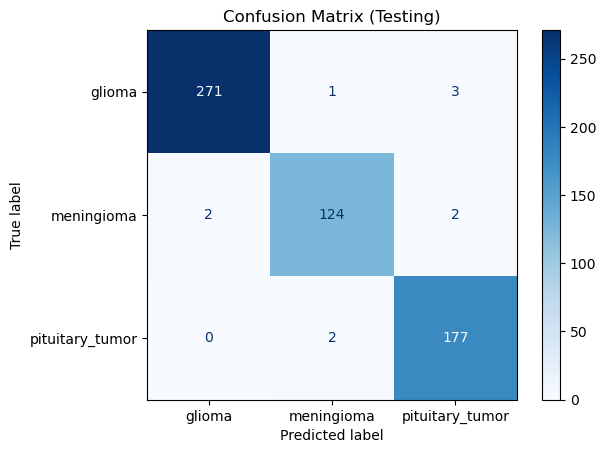

In [34]:
SEED = 42 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

evaluate_training_testing_model(model=model, 
                                train_dataloader=train_dataloader, 
                                test_dataloader=test_dataloader, 
                                class_names=class_names, 
                                device=device)


#### Evaluate overall without AUG

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:07<00:00,  2.38it/s]


=== Training Metrics ===
Training Accuracy: 0.9886
Training Precision: 0.9888
Training Recall: 0.9886
Training F1-Score: 0.9887
Overall Training Specificity: 0.9935

=== Testing Metrics ===
Testing Accuracy: 0.9708
Testing Precision: 0.9725
Testing Recall: 0.9708
Testing F1-Score: 0.9711
Overall Testing Specificity: 0.9841


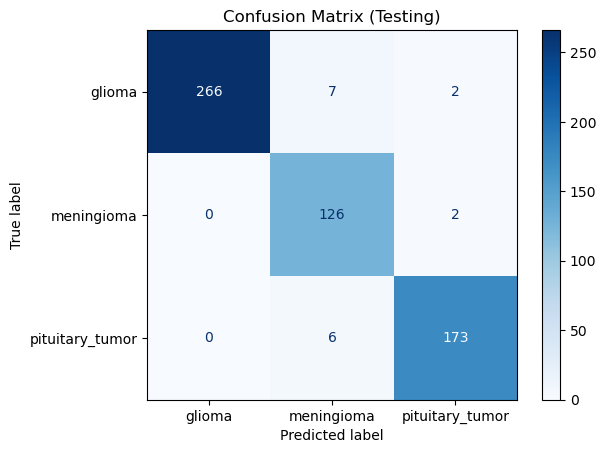

In [84]:
SEED = 42 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

evaluate_training_testing_model(model=model, 
                                train_dataloader=train_dataloader, 
                                test_dataloader=test_dataloader, 
                                class_names=class_names, 
                                device=device)


# ConvNext small 

In [35]:
weights = torchvision.models.ConvNeXt_Small_Weights.DEFAULT
auto_transforms_convnext_small = weights.transforms()

train_dataloader, test_dataloader, class_names=create_dataloaders(train_dir, test_dir, transform=auto_transforms_convnext_small, batch_size=BATCH_SIZE)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x273ec0b1b90>,
 ['glioma', 'meningioma', 'pituitary_tumor'])

In [35]:
model = torchvision.models.convnext_small(weights=weights_small).to(device)

# Update the classifier head of our model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for param in model.features.parameters():
    param.requires_grad = False

# Define the new classifier head

model.classifier = nn.Sequential(
    # nn.LayerNorm([BATCH_SIZE, 1024, 1 ,1]),
    nn.Flatten(),
    nn.BatchNorm1d(num_features=768),  # Batch Norm after Global Average Pooling   
    nn.Linear(in_features=768, out_features=512, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=512),   # Batch Norm after first Linear layer
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=512, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256),   # Batch Norm after second Linear layer
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=256, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256),
    nn.Linear(in_features=256, out_features=len(class_names), bias=True)
)


# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move model to the appropriate device
model = model.to(device)

summary(model=model,
       input_size=(32, 3, 224, 224), #example of [batch_size, color_channels, height, width]
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names']) 

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 768, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 96, 56, 56]     --                   False
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 96, 56, 56]     (4,704)              False
│    │    └─LayerNorm2d (1)                             [32, 96, 56, 56]     [32, 96, 56, 56]     (192)                False
│    └─Sequential (1)                                   [32, 96, 56, 56]     [32, 96, 56, 56]     --                   False
│    │    └─CNBlock (0)                                 [32, 96, 56, 56]     [32, 96, 56, 56]     (79,296)             

In [ ]:
# AUG

# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# Start the timer
start_time = timer()

# setup training and save the result
results = engine.train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader= test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=100,
                      device=device)

# End the timer 
end_time = timer()

print(f'[INGO] Total training time: {end_time - start_time:.3f} seconds')

# we got 98.68

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3895 | train_acc: 0.8482 | test_loss: 0.1591 | test_acc: 0.9402
Epoch: 2 | train_loss: 0.2789 | train_acc: 0.8944 | test_loss: 0.1462 | test_acc: 0.9348
Epoch: 3 | train_loss: 0.2551 | train_acc: 0.9077 | test_loss: 0.1687 | test_acc: 0.9337
Epoch: 4 | train_loss: 0.2454 | train_acc: 0.9060 | test_loss: 0.1459 | test_acc: 0.9413
Epoch: 5 | train_loss: 0.1966 | train_acc: 0.9238 | test_loss: 0.1198 | test_acc: 0.9605
Epoch: 6 | train_loss: 0.1924 | train_acc: 0.9285 | test_loss: 0.1370 | test_acc: 0.9512
Epoch: 7 | train_loss: 0.1946 | train_acc: 0.9332 | test_loss: 0.1025 | test_acc: 0.9655
Epoch: 8 | train_loss: 0.1987 | train_acc: 0.9303 | test_loss: 0.1117 | test_acc: 0.9550
Epoch: 9 | train_loss: 0.1974 | train_acc: 0.9306 | test_loss: 0.0914 | test_acc: 0.9655
Epoch: 10 | train_loss: 0.1602 | train_acc: 0.9410 | test_loss: 0.0973 | test_acc: 0.9583
Epoch: 11 | train_loss: 0.1810 | train_acc: 0.9375 | test_loss: 0.1118 | test_acc: 0.9561
Epoch: 12 | train_l

In [ ]:
# save the model 
torch.save(model.state_dict(), 'ConvNextSmallAug.pth')

In [24]:
# Train ConvNeXt small with no data aug 
# Set the manual seeds 

# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# Start the timer
start_time = timer()

# setup training and save the result
results = engine.train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader= test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=100,
                      device=device)

# End the timer 
end_time = timer()

print(f'[INGO] Total training time: {end_time - start_time:.3f} seconds')

# we got 98.68

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3857 | train_acc: 0.8487 | test_loss: 0.1667 | test_acc: 0.9320
Epoch: 2 | train_loss: 0.2469 | train_acc: 0.9057 | test_loss: 0.1432 | test_acc: 0.9419
Epoch: 3 | train_loss: 0.2383 | train_acc: 0.9170 | test_loss: 0.1560 | test_acc: 0.9424
Epoch: 4 | train_loss: 0.1989 | train_acc: 0.9242 | test_loss: 0.1363 | test_acc: 0.9550
Epoch: 5 | train_loss: 0.1685 | train_acc: 0.9378 | test_loss: 0.1140 | test_acc: 0.9589
Epoch: 6 | train_loss: 0.1682 | train_acc: 0.9379 | test_loss: 0.1011 | test_acc: 0.9655
Epoch: 7 | train_loss: 0.1533 | train_acc: 0.9462 | test_loss: 0.1098 | test_acc: 0.9589
Epoch: 8 | train_loss: 0.1502 | train_acc: 0.9437 | test_loss: 0.1028 | test_acc: 0.9572
Epoch: 9 | train_loss: 0.1601 | train_acc: 0.9444 | test_loss: 0.0910 | test_acc: 0.9688
Epoch: 10 | train_loss: 0.1322 | train_acc: 0.9544 | test_loss: 0.0864 | test_acc: 0.9655
Epoch: 11 | train_loss: 0.1562 | train_acc: 0.9392 | test_loss: 0.1083 | test_acc: 0.9534
Epoch: 12 | train_l

In [25]:
# save the model 
torch.save(model.state_dict(), 'ConvNextSmall.pth')

### Evaluate the model 

#### Evaluate class-wise

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:08<00:00,  2.18it/s]

Overall Accuracy: 0.9759

Classification Report:
                 precision    recall  f1-score   support

         glioma     0.9891    0.9855    0.9872       275
     meningioma     0.9318    0.9609    0.9462       128
pituitary_tumor     0.9886    0.9721    0.9803       179

       accuracy                         0.9759       582
      macro avg     0.9698    0.9728    0.9712       582
   weighted avg     0.9763    0.9759    0.9761       582

Accuracy for glioma: 0.9855
Accuracy for meningioma: 0.9609
Accuracy for pituitary_tumor: 0.9721
Specificity for glioma: 0.9902
Specificity for meningioma: 0.9802
Specificity for pituitary_tumor: 0.9950


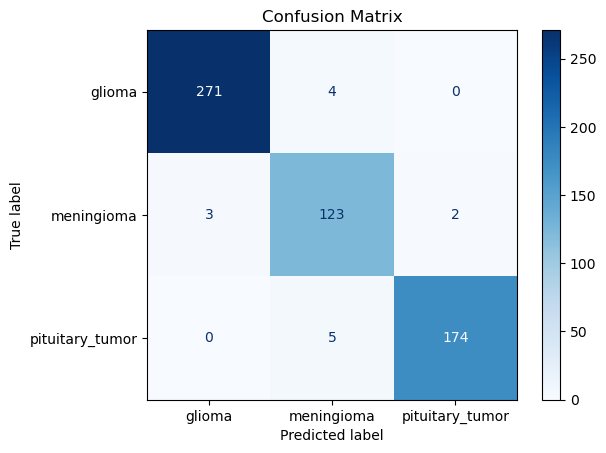

In [79]:
# Add seeding 
SEED = 50 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Step 1: Load the Saved Model
model = torchvision.models.convnext_small(weights=None).to(device)  # Use the same model architecture
# Step 2: make sure all the hyperparameters are the same  ( you have to change the code below depending on the model you add)
model.classifier = nn.Sequential(
    # nn.LayerNorm([BATCH_SIZE, 1024, 1 ,1]),
    nn.Flatten(),
    nn.BatchNorm1d(num_features=768),  # Batch Norm after Global Average Pooling   
    nn.Linear(in_features=768, out_features=512, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=512),   # Batch Norm after first Linear layer
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=512, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256),   # Batch Norm after second Linear layer
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=256, out_features=256, bias=True),
    nn.SiLU(),
    nn.BatchNorm1d(num_features=256),
    nn.Linear(in_features=256, out_features=len(class_names), bias=True)
)

model.load_state_dict(torch.load("ConvNextSmallAug.pth"))  # Load the model weights
model.to(device)


evaluate_model(model=model, test_dataloader=test_dataloader, class_names=class_names, device=device)


#### Evaluate over-all classes with AUG

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:08<00:00,  2.13it/s]


=== Training Metrics ===
Training Accuracy: 0.9969
Training Precision: 0.9969
Training Recall: 0.9969
Training F1-Score: 0.9969
Overall Training Specificity: 0.9985

=== Testing Metrics ===
Testing Accuracy: 0.9759
Testing Precision: 0.9760
Testing Recall: 0.9759
Testing F1-Score: 0.9759
Overall Testing Specificity: 0.9885


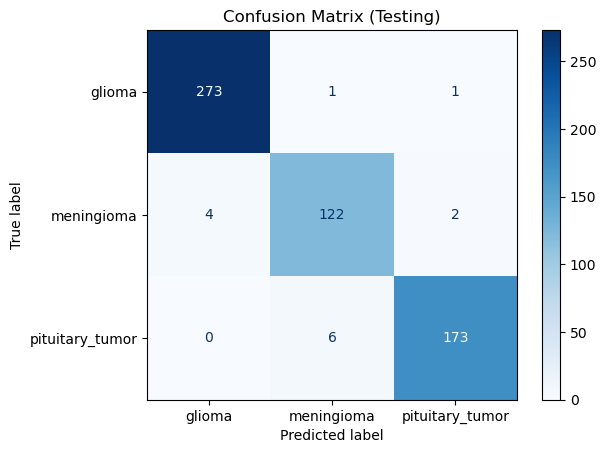

In [71]:
SEED = 50 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

evaluate_training_testing_model(model=model, 
                                train_dataloader=train_dataloader, 
                                test_dataloader=test_dataloader, 
                                class_names=class_names, 
                                device=device)


#### Evaluate over all without AUG

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:09<00:00,  2.04it/s]


=== Training Metrics ===
Training Accuracy: 0.9829
Training Precision: 0.9836
Training Recall: 0.9829
Training F1-Score: 0.9831
Overall Training Specificity: 0.9908

=== Testing Metrics ===
Testing Accuracy: 0.9656
Testing Precision: 0.9676
Testing Recall: 0.9656
Testing F1-Score: 0.9660
Overall Testing Specificity: 0.9821


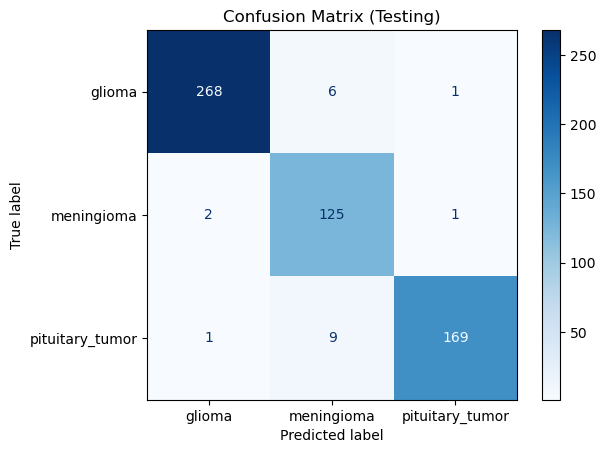

In [87]:
SEED = 42 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

evaluate_training_testing_model(model=model, 
                                train_dataloader=train_dataloader, 
                                test_dataloader=test_dataloader, 
                                class_names=class_names, 
                                device=device)


# show random samples of augmentation

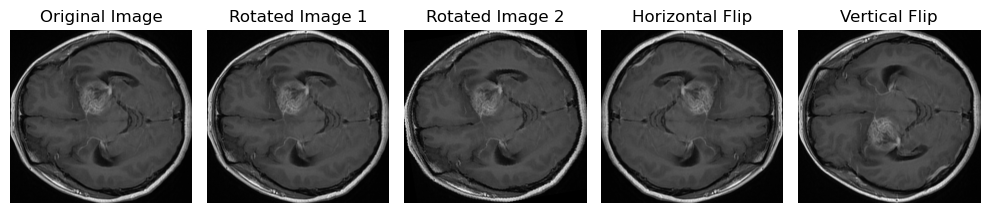

In [4]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import os

# Load the image
image_path = r"C:\Users\ROG\Desktop\deep-learning\brain_tumor\data\filtered_images\2nd_data\Training\glioma\726.png"  # Replace with your image path
image = Image.open(image_path)

# Define transformations
rotation_transform = transforms.RandomRotation(degrees=15)
horizontal_flip_transform = transforms.RandomHorizontalFlip(p=1.0)
vertical_flip_transform = transforms.RandomVerticalFlip(p=1.0)

# Apply transformations
rotated_image_1 = rotation_transform(image)
rotated_image_2 = rotation_transform(image)
horizontal_flipped_image = horizontal_flip_transform(image)
vertical_flipped_image = vertical_flip_transform(image)

# Save images
save_dir = "augmented_images"  # Directory to save the images
os.makedirs(save_dir, exist_ok=True)

image.save(os.path.join(save_dir, "original_image.jpg"))
rotated_image_1.save(os.path.join(save_dir, "rotated_image_1.jpg"))
rotated_image_2.save(os.path.join(save_dir, "rotated_image_2.jpg"))
horizontal_flipped_image.save(os.path.join(save_dir, "horizontal_flipped_image.jpg"))
vertical_flipped_image.save(os.path.join(save_dir, "vertical_flipped_image.jpg"))

# Plot and show images
plt.figure(figsize=(10, 8))

plt.subplot(1, 5, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(rotated_image_1)
plt.title("Rotated Image 1")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(rotated_image_2)
plt.title("Rotated Image 2")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(horizontal_flipped_image)
plt.title("Horizontal Flip")
plt.axis("off")

plt.subplot(1, 5, 5)
plt.imshow(vertical_flipped_image)
plt.title("Vertical Flip")
plt.axis("off")

plt.tight_layout()
plt.show()
